2024-08-15 21:23:06.559715: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-15 21:23:06.559767: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-15 21:23:06.561190: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-15 21:23:06.569555: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-15 21:23:07.595267: W tensorflow/compiler/tf2

389
389
567
567


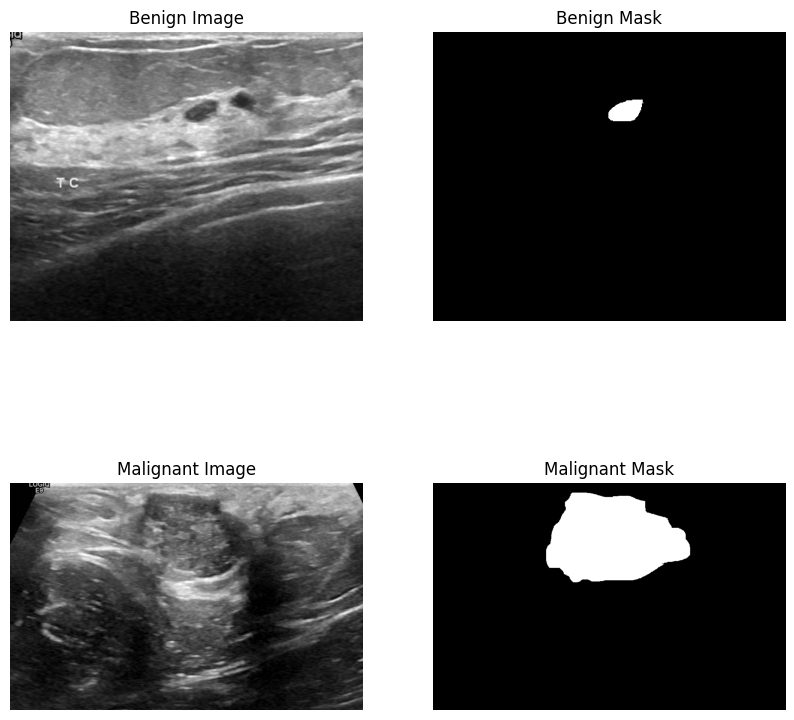

In [1]:
# loading the Libraries 
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define the data directory
data_dir = '/home/ubuntu/BTS/Breast_Cancer_Segmentation/Dataset_BUSI_with_GT' # change the path of the directory
categories = ['benign', 'malignant']

# Function to load and visualize data
def load_and_visualize_data(data_dir, categories):
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    
    for i, category in enumerate(categories):
        category_dir = os.path.join(data_dir, category)
        images = [f for f in os.listdir(category_dir) if f.endswith('.png') and '_mask' not in f]
        
        img_path = os.path.join(category_dir, images[0])
        mask_path = os.path.join(category_dir, images[0].replace('.png', '_mask.png'))
        
        image = img_to_array(load_img(img_path, color_mode='grayscale'))
        mask = img_to_array(load_img(mask_path, color_mode='grayscale'))
        print(len(image))
        print(len(mask))
        
        axes[i, 0].imshow(image.squeeze(), cmap='gray')
        axes[i, 0].set_title(f'{category.capitalize()} Image')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(mask.squeeze(), cmap='gray')
        axes[i, 1].set_title(f'{category.capitalize()} Mask')
        axes[i, 1].axis('off')
    
    plt.show()

# Visualize the data
load_and_visualize_data(data_dir, categories)


### Split the Data into Train, Validation, and Test Sets

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split

# Function to get image and mask pairs
def get_image_mask_pairs(data_dir, categories):
    image_paths = []
    mask_paths = []
    
    for category in categories:
        category_dir = os.path.join(data_dir, category)
        images = [f for f in os.listdir(category_dir) if f.endswith('.png') and '_mask' not in f]
        
        for image in images:
            img_path = os.path.join(category_dir, image)
            mask_path = os.path.join(category_dir, image.replace('.png', '_mask.png'))
            image_paths.append(img_path)
            mask_paths.append(mask_path)
    
    return np.array(image_paths), np.array(mask_paths)

# Get image and mask pairs
image_paths, mask_paths = get_image_mask_pairs(data_dir, categories)

# Split the data
train_img_paths, test_img_paths, train_mask_paths, test_mask_paths = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)
train_img_paths, val_img_paths, train_mask_paths, val_mask_paths = train_test_split(train_img_paths, train_mask_paths, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Summary of the splits
print(f"Training set size: {len(train_img_paths)}")
print(f"Validation set size: {len(val_img_paths)}")
print(f"Test set size: {len(test_img_paths)}")


Training set size: 387
Validation set size: 130
Test set size: 130


###  Augment the Data

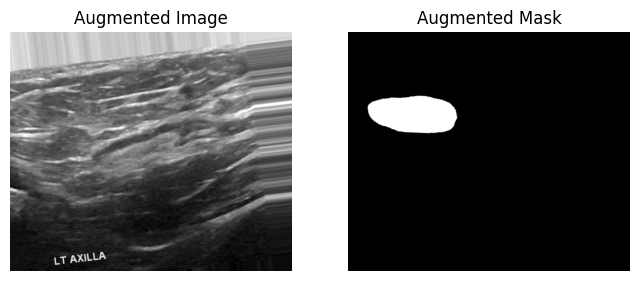

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation
data_gen_args = dict(rotation_range=10,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.1,
                     zoom_range=0.1,
                     horizontal_flip=True,
                     fill_mode='nearest')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Example of applying augmentation to an image and its mask
def augment_data(img_path, mask_path, image_datagen, mask_datagen):
    img = img_to_array(load_img(img_path, color_mode='grayscale'))
    mask = img_to_array(load_img(mask_path, color_mode='grayscale'))
    
    img = img.reshape((1,) + img.shape)
    mask = mask.reshape((1,) + mask.shape)
    
    img_gen = image_datagen.flow(img, batch_size=1)
    mask_gen = mask_datagen.flow(mask, batch_size=1)
    
    img_aug, mask_aug = next(img_gen), next(mask_gen)
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(img_aug[0].squeeze(), cmap='gray')
    axes[0].set_title('Augmented Image')
    axes[0].axis('off')
    
    axes[1].imshow(mask_aug[0].squeeze(), cmap='gray')
    axes[1].set_title('Augmented Mask')
    axes[1].axis('off')
    
    plt.show()

# Example usage
augment_data(train_img_paths[0], train_mask_paths[0], image_datagen, mask_datagen)


### Design a U-Net Model

In [4]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model

def unet_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)
    
    # Contracting Path
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    
    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    
    # Expanding Path
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    
    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    
    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Initialize the model
model = unet_model()
model.summary()


2024-08-15 21:23:10.182941: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-15 21:23:10.237104: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-15 21:23:10.237373: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

### Train the Model

In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def create_generators(image_paths, mask_paths, batch_size, image_datagen, mask_datagen):
    while True:
        for i in range(0, len(image_paths), batch_size):
            batch_img_paths = image_paths[i:i + batch_size]
            batch_mask_paths = mask_paths[i:i + batch_size]
            
            img_batch = np.array([img_to_array(load_img(img_path, color_mode='grayscale', target_size=(256, 256))) for img_path in batch_img_paths])
            mask_batch = np.array([img_to_array(load_img(mask_path, color_mode='grayscale', target_size=(256, 256))) for mask_path in batch_mask_paths])
            
            img_batch = img_batch.astype('float32') / 255.0
            mask_batch = mask_batch.astype('float32') / 255.0
            
            img_gen = image_datagen.flow(img_batch, batch_size=batch_size, shuffle=True, seed=42)
            mask_gen = mask_datagen.flow(mask_batch, batch_size=batch_size, shuffle=True, seed=42)
            
            yield next(img_gen), next(mask_gen)

# Generators for training and validation
train_generator = create_generators(train_img_paths, train_mask_paths, 16, image_datagen, mask_datagen)
val_generator = create_generators(val_img_paths, val_mask_paths, 16, image_datagen, mask_datagen)

# Callbacks
checkpoint = ModelCheckpoint('unet_model.h5', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) # stop training when the model stops learning

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_img_paths) // 16,
    validation_data=val_generator,
    validation_steps=len(val_img_paths) // 16,
    epochs=100
    #callbacks=[checkpoint, early_stopping]
)

Epoch 1/100


2024-08-15 21:23:14.237960: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-08-15 21:23:14.401801: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-08-15 21:23:22.330819: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-08-15 21:23:23.041847: I external/local_xla/xla/service/service.cc:168] XLA service 0x732957e80720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-15 21:23:23.041885: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
2024-08-15 21:23:23.048838: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1723757003.163524    4957 device_compiler.h:1

24/24 [==============================] - 36s 373ms/step - loss: 1.9435 - accuracy: 0.8711 - val_loss: 0.3499 - val_accuracy: 0.8939
Epoch 2/100
24/24 [==============================] - 15s 398ms/step - loss: 0.3319 - accuracy: 0.9035 - val_loss: 0.3145 - val_accuracy: 0.9055
Epoch 3/100
24/24 [==============================] - 8s 326ms/step - loss: 0.3168 - accuracy: 0.9031 - val_loss: 0.3261 - val_accuracy: 0.8928
Epoch 4/100
24/24 [==============================] - 7s 312ms/step - loss: 0.3133 - accuracy: 0.9038 - val_loss: 0.3245 - val_accuracy: 0.8918
Epoch 5/100
24/24 [==============================] - 7s 311ms/step - loss: 0.3551 - accuracy: 0.9050 - val_loss: 0.3526 - val_accuracy: 0.8908
Epoch 6/100
24/24 [==============================] - 7s 311ms/step - loss: 0.3206 - accuracy: 0.9058 - val_loss: 0.3349 - val_accuracy: 0.8917
Epoch 7/100
24/24 [==============================] - 7s 311ms/step - loss: 0.3156 - accuracy: 0.9059 - val_loss: 0.3321 - val_accuracy: 0.8917
Epoch 8/1

### Visualize the Model Performance

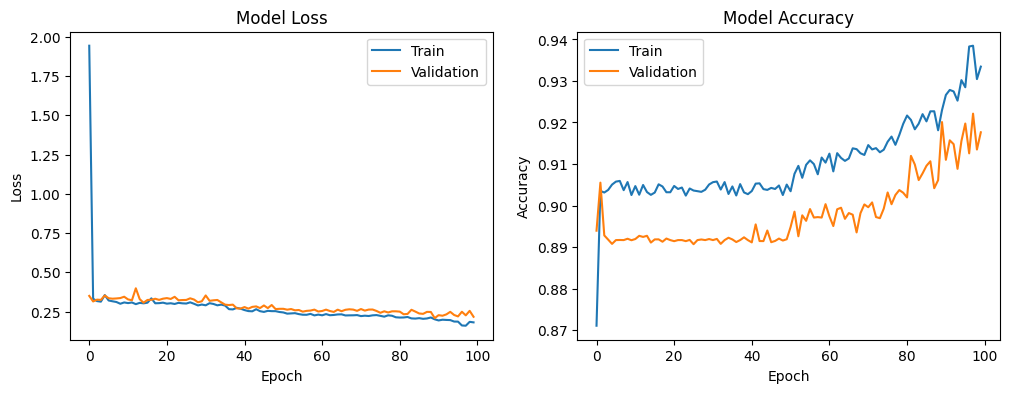

In [6]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    
    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.show()

# Visualize the performance
plot_training_history(history)


### Test the Model Performance on the Test Set

1/1 [==============================] - 2s 2s/step


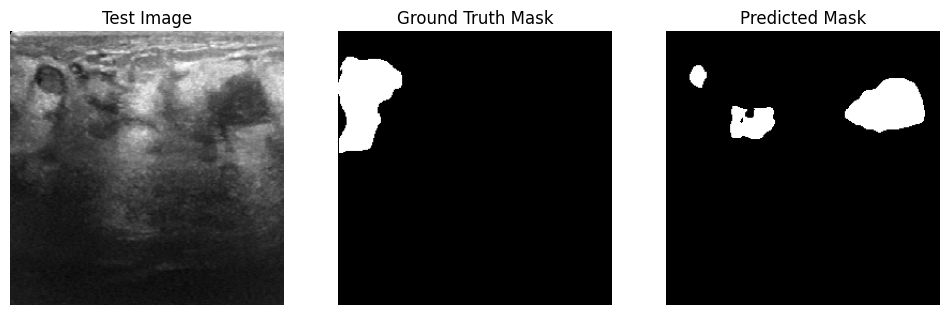

1/1 [==============================] - 0s 21ms/step


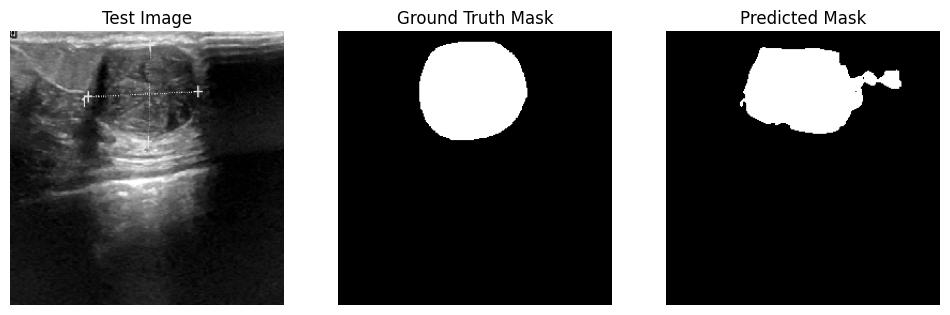

1/1 [==============================] - 0s 22ms/step


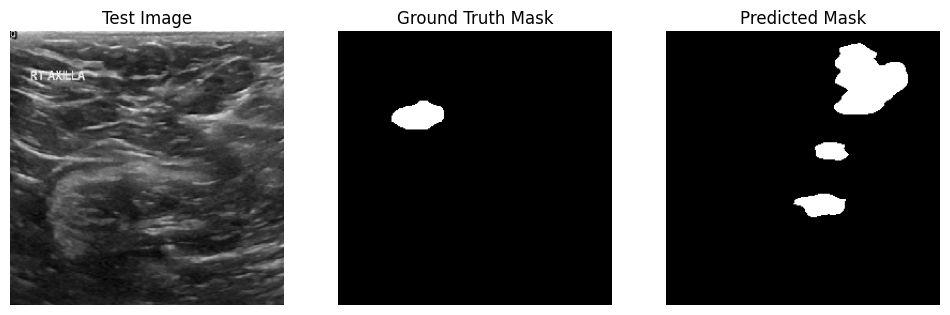

1/1 [==============================] - 0s 21ms/step


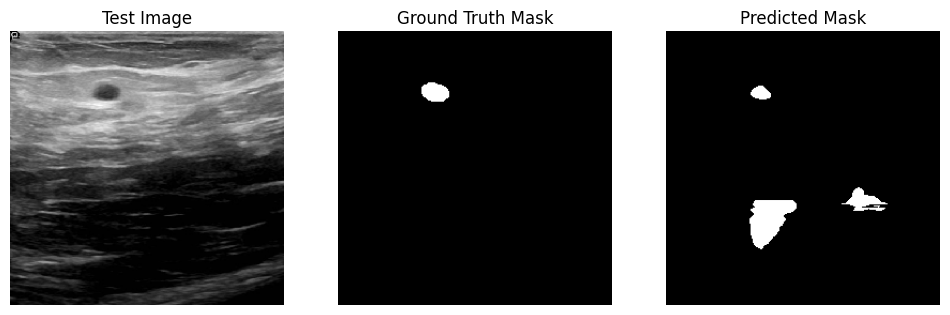

1/1 [==============================] - 0s 21ms/step


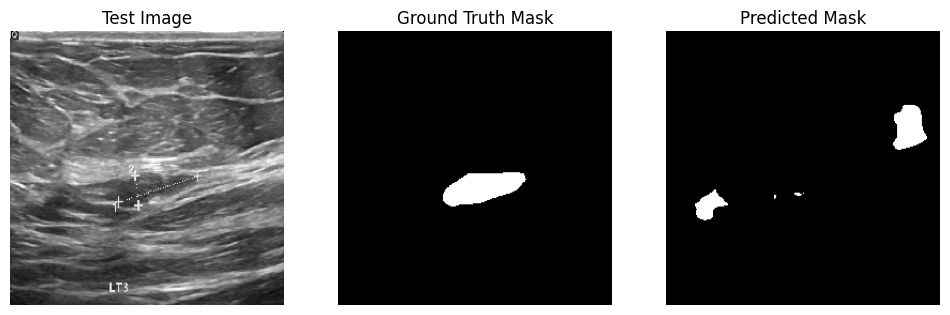

In [7]:
import matplotlib.pyplot as plt

def visualize_predictions(model, test_img_paths, test_mask_paths, num_samples=5):
    """
    Visualizes the test images, ground truth masks, and predicted masks.
    
    Parameters:
    - model: Trained U-Net model.
    - test_img_paths: List of paths to test images.
    - test_mask_paths: List of paths to ground truth masks for the test images.
    - num_samples: Number of samples to visualize.
    """
    for i in range(num_samples):
        # Load and preprocess the test image and its corresponding mask
        img_path = test_img_paths[i]
        mask_path = test_mask_paths[i]
        
        img = img_to_array(load_img(img_path, color_mode='grayscale', target_size=(256, 256))) / 255.0
        mask = img_to_array(load_img(mask_path, color_mode='grayscale', target_size=(256, 256))) / 255.0
        
        # Predict the mask
        pred_mask = model.predict(img.reshape(1, 256, 256, 1))
        pred_mask = (pred_mask > 0.5).astype(int).reshape(256, 256)
        
        # Plot the image, ground truth mask, and predicted mask
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 3, 1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title('Test Image')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(mask.squeeze(), cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask, cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
        
        plt.show()

# Example usage:
visualize_predictions(model, test_img_paths, test_mask_paths, num_samples=5)


1/1 [==============================] - 0s 21ms/step


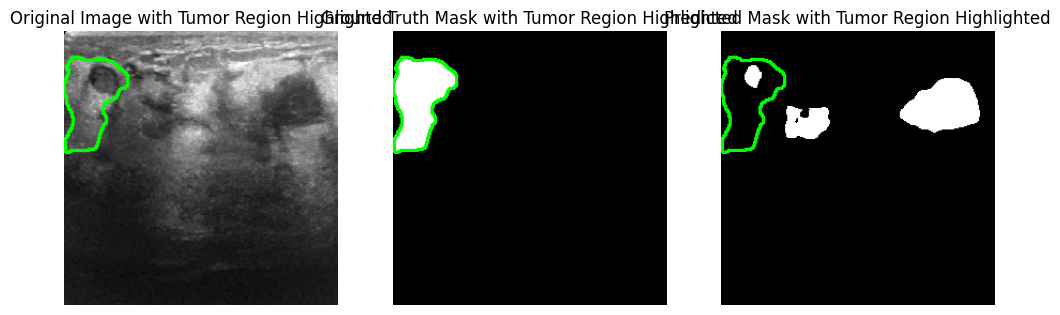

1/1 [==============================] - 0s 21ms/step


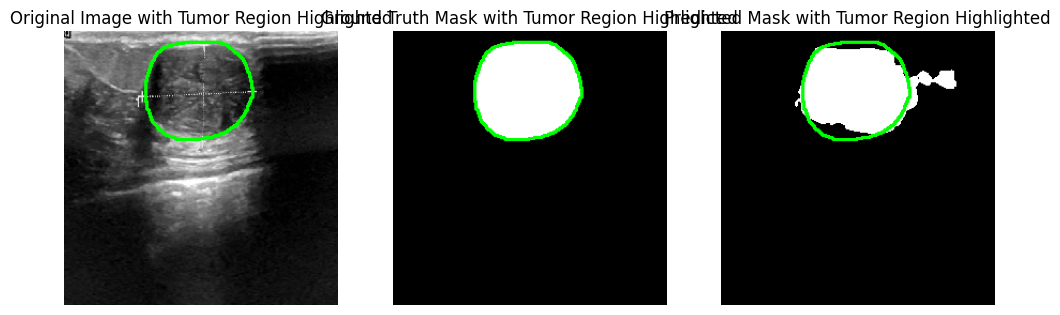

1/1 [==============================] - 0s 22ms/step


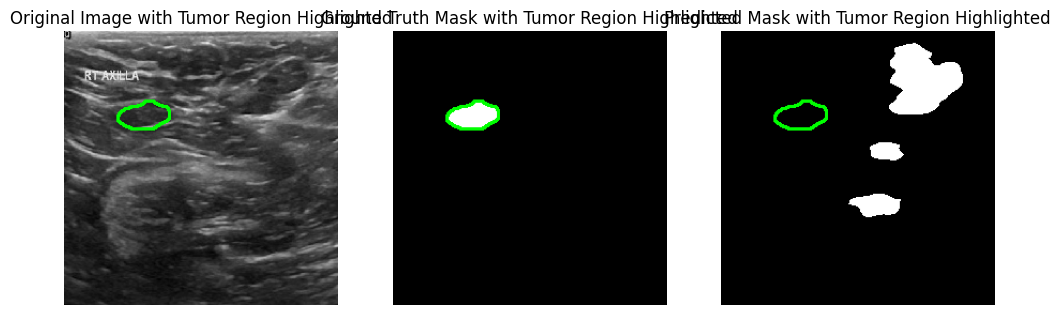

1/1 [==============================] - 0s 21ms/step


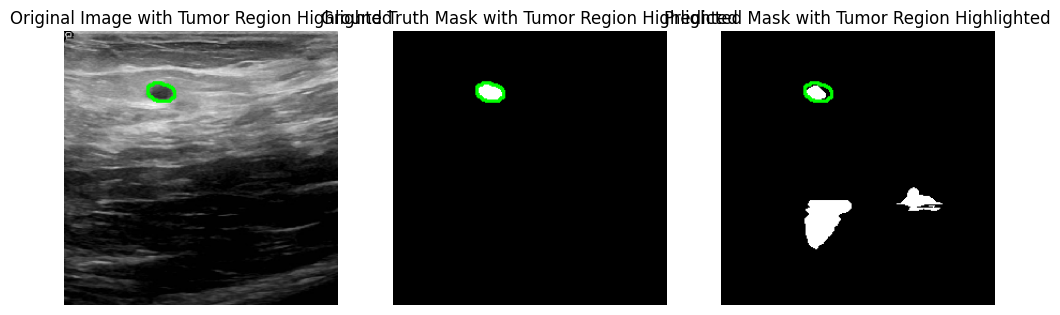

1/1 [==============================] - 0s 21ms/step


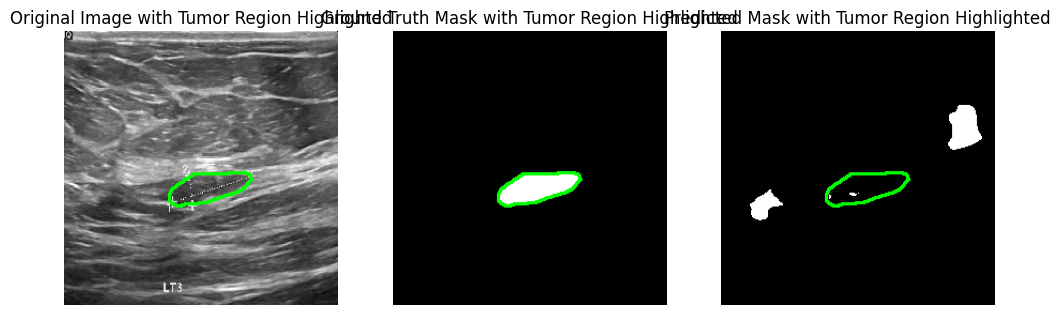

In [8]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def visualize_traced_tumor_region_with_gt_contour(model, test_img_paths, test_mask_paths, num_samples=5):
    """
    Visualizes the test images, ground truth masks, and predicted masks with the tumor region traced
    from the ground truth mask and highlighted on the original image, ground truth mask, and predicted mask.
    
    Parameters:
    - model: Trained U-Net model.
    - test_img_paths: List of paths to test images.
    - test_mask_paths: List of paths to ground truth masks for the test images.
    - num_samples: Number of samples to visualize.
    """
    for i in range(num_samples):
        # Load and preprocess the test image and its corresponding mask
        img_path = test_img_paths[i]
        mask_path = test_mask_paths[i]
        
        img = img_to_array(load_img(img_path, color_mode='grayscale', target_size=(256, 256))) / 255.0
        mask = img_to_array(load_img(mask_path, color_mode='grayscale', target_size=(256, 256))) / 255.0
        
        # Predict the mask
        pred_mask = model.predict(img.reshape(1, 256, 256, 1))
        pred_mask = (pred_mask > 0.5).astype(int).reshape(256, 256)
        
        # Convert images and masks to uint8 for contour detection
        img_uint8 = (img.squeeze() * 255).astype(np.uint8)
        mask_uint8 = (mask.squeeze() * 255).astype(np.uint8)
        pred_mask_uint8 = (pred_mask * 255).astype(np.uint8)
        
        # Find contours for the ground truth mask
        contours_gt, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Create copies of the images for drawing
        img_with_contour = cv2.cvtColor(img_uint8, cv2.COLOR_GRAY2RGB)
        mask_with_contour = cv2.cvtColor(mask_uint8, cv2.COLOR_GRAY2RGB)
        pred_mask_with_contour = cv2.cvtColor(pred_mask_uint8, cv2.COLOR_GRAY2RGB)
        
        # Draw the tumor region contour from the ground truth mask onto the original image, ground truth mask, and predicted mask
        if contours_gt:
            cv2.drawContours(img_with_contour, contours_gt, -1, (0, 255, 0), 2)  # Green contour on original image
            cv2.drawContours(mask_with_contour, contours_gt, -1, (0, 255, 0), 2)  # Green contour on ground truth mask
            cv2.drawContours(pred_mask_with_contour, contours_gt, -1, (0, 255, 0), 2)  # Green contour on predicted mask
        
        # Plot the image, ground truth mask, and predicted mask with the tumor region highlighted
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 3, 1)
        plt.imshow(img_with_contour)
        plt.title('Original Image with Tumor Region Highlighted')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(mask_with_contour)
        plt.title('Ground Truth Mask with Tumor Region Highlighted')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask_with_contour)
        plt.title('Predicted Mask with Tumor Region Highlighted')
        plt.axis('off')
        
        plt.show()

# Example usage:
visualize_traced_tumor_region_with_gt_contour(model, test_img_paths, test_mask_paths, num_samples=5)
